In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import WUBRG
import consts
from LineColors import LineColors
from FormatMetadata import SETS, FORMATS, SET_CONFIG
from JSONHandler import JSONHandler
from FormatMetadata import FormatMetadata
from RawDataFetcher import RawDataFetcher

#plt.style.use(plt.style.available[13])  ##4, 13, 21
#sns.set_context("paper")
#sns.set_theme()
#plt.style.available[13]

# Objects

In [2]:
from datetime import date, time, datetime, timedelta
import pandas as pd

import WUBRG
import consts
from JSONHandler import JSONHandler
from RawDataFetcher import RawDataFetcher

class RawDataHandler:    
    
    #TODO: Revamp this by having it use the new fetcher object and properties
    # which can help to auto-load data.
    
    def __init__(self, SET, FORMAT):
        self._SET = SET
        self._FORMAT = FORMAT
        self.FORMAT_METADATA = FormatMetadata(SET, FORMAT)
        
        self._SUMMARY_DICT = dict()
        self._ARCHTYPE_DICT = dict()
        self._CARD_DICTS = dict()
        
        self.SUMMARY_FRAME = None
        self.ARCHTYPE_FRAME = None
        self.CARD_FRAME = None
    
    
    @property
    def SET(self):
        """The draft set."""
        return self._SET
    
    
    @property
    def FORMAT(self):
        """The queue type."""
        return self._FORMAT
    
    
    def panadafy_card_dict(self, card_dict: dict) -> pd.DataFrame:
        """
        Turns a dictionary into a DataFrame, with some data cleaning applied.
        :param card_dict: The dictionary containing card data for a colour group
        :return: A DataFrame filled with the cleaned card data
        """
        frame = pd.DataFrame.from_dict(card_dict)
        frame = frame.rename(columns=consts.STAT_NAMES)

        # If there's no data, make a blank frame and return it.
        if len(card_dict) == 0:
            return frame

        frame = frame.set_index('Name')
        
        for col in ["GP WR", "OH WR", "GD WR", "GIH WR", "GND WR", "IWD"]:
            frame[col] = frame[col] * 100

        frame = frame.drop(['sideboard_game_count', 'sideboard_win_rate', 'url', 'url_back'], axis=1)
        frame['Rarity'] = frame['Rarity'].map(consts.RARITY_ALIASES)
        frame = frame.round(3)
        return frame
    
    def panadafy_meta_dict(self, meta_dict: dict) -> pd.DataFrame:
        """
        Turns a dictionary into a DataFrame, with some data cleaning applied.
        :param card_dict: The dictionary containing card data for a colour group
        :return: A DataFrame filled with the cleaned card data
        """
        frame = pd.DataFrame.from_dict(meta_dict)
        frame = frame.rename(columns=consts.META_COLS)

        # If there's no data, make a blank frame and return it.
        if len(meta_dict) == 0:
            return frame, frame.copy()
        
        frame['Name'] = frame['Color Name']
        frame = frame.set_index('Name')
        frame['Win %'] = round((frame['Wins'] / frame['Games']) * 100, 2)
        frame['Splash'] = frame['Color Name'].str.contains("Splash", case=False)
        frame['Colors'] = frame['Color Name'].map(lambda x: x.replace(' + Splash', ''))
        frame = frame[['Colors', 'Splash', 'Wins', 'Games', 'Win %', 'is_summary']]
        
        summary_frame = frame[frame['is_summary'] == True].copy()
        summary_frame = summary_frame.drop(['is_summary'], axis=1)
        summary_frame['Colors'] = summary_frame['Colors'].map(WUBRG.COLOR_COUNT_MAP)

        archetype_frame = frame[frame['is_summary'] == False].copy()
        archetype_frame = archetype_frame.drop(['is_summary'], axis=1)
        archetype_frame['Colors'] = archetype_frame['Colors'].map(lambda x: x[0: (x.find('(') if x.find('(') != -1 else len(x))].strip())
        archetype_frame['Colors'] = archetype_frame['Colors'].map(lambda x: x.replace('Mono-', ''))
        archetype_frame['Colors'] = archetype_frame['Colors'].map(WUBRG.COLOR_ALIASES)
        archetype_frame['Name'] = archetype_frame['Colors']
        archetype_frame = archetype_frame.set_index('Name')

        return summary_frame, archetype_frame
    
    def gen_frames(self):
        self.SUMMARY_FRAME = pd.concat(self._SUMMARY_DICT, names=["Date", "Name"])
        self.ARCHTYPE_FRAME = pd.concat(self._ARCHTYPE_DICT, names=["Date", "Name"])
        temp_dict = dict()
        for date in self._CARD_DICTS:
            temp_dict[date] = pd.concat(self._CARD_DICTS[date], names=["Deck Colors", "Name"])
        self.CARD_FRAME = pd.concat(temp_dict, names=["Date", "Deck Colors", "Name"])
        
    def get_day_data(self, check_date):
        loader = JSONHandler(self.SET, self.FORMAT, check_date)
        str_date = str(check_date)
        print(f'Getting data for {self.SET} {self.FORMAT}, date: {str_date}')
        card_dict, meta_dict = loader.get_day_data()
        
        self._SUMMARY_DICT[str_date], self._ARCHTYPE_DICT[str_date] = self.panadafy_meta_dict(meta_dict)
        self._CARD_DICTS[str_date] = dict()
        for color in card_dict:
            self._CARD_DICTS[str_date][color] = self.panadafy_card_dict(card_dict[color])
            
        return self._SUMMARY_DICT[str_date], self._ARCHTYPE_DICT[str_date], self._CARD_DICTS[str_date]

    def get_set_data(self):
        check_date = self.FORMAT_METADATA.START_DATE

        run = True        
        while(run):
            if self.FORMAT_METADATA.is_active(check_date):
                self.get_day_data(check_date)
            check_date += timedelta(days=1)
            #TODO: Make this more in line with the time check for general data.
            run = check_date < date.today() 
    
        self.gen_frames()
        return self._SUMMARY_DICT, self._ARCHTYPE_DICT, self._CARD_DICTS
    
    def get_summary_data(self):
        loader = JSONHandler(self.SET, self.FORMAT, None)
        print(f'Getting overall data for {self.SET} {self.FORMAT}')
        card_dict, meta_dict = loader.get_day_data(overwrite=True)
        
        summary, archetype = self.panadafy_meta_dict(meta_dict)
        cards = dict()
        for color in card_dict:
            cards[color] = self.panadafy_card_dict(card_dict[color])
            
        return summary, archetype, cards

In [3]:
class RawDataWrapper:   
    def __init__(self, SET, FORMAT):
        self._SET = SET
        self._FORMAT = FORMAT
        self._DATA = RawDataHandler(SET, FORMAT)
    
    
    @property
    def SET(self):
        """The draft set."""
        return self._SET
    
    
    @property
    def FORMAT(self):
        """The format type."""
        return self._FORMAT
    
    
    @property
    def DATA(self):
        """The data about the set and format."""
        return self._DATA
    

    def get_set_data(self):
        self.DATA.get_set_data()
        
    def get_summary_data(self):
        return self.DATA.get_summary_data()
    
    def summary_frame(self, date=slice(None, None, None), name=slice(None, None, None)):
        return self.DATA.SUMMARY_FRAME.loc(axis=0)[pd.IndexSlice[date, name]]
     
    def archetype_frame(self, date=slice(None, None, None), name=slice(None, None, None)):
        return self.DATA.ARCHTYPE_FRAME.loc(axis=0)[pd.IndexSlice[date, name]]
    
    def card_frame(self, date=slice(None, None, None), colors=slice(None, None, None), name=slice(None, None, None)):
        return self.DATA.CARD_FRAME.loc(axis=0)[pd.IndexSlice[date, colors, name]]

In [4]:
class DataManager:
    def __init__(self):        
        self.DATA = {s: {f: RawDataWrapper(s, f) for f in FORMATS} for s in SETS}
        
        self._SET = SETS[0]
        self._FORMAT = FORMATS[0]
        self._ACTIVE_DATA = self.DATA[self._SET][self._FORMAT]
        
    @property
    def SET(self):
        """The draft set."""
        return self._SET

    @SET.setter
    def SET(self, value):
        if value in SETS:
            self._SET = value
            self._ACTIVE_DATA = self.DATA[self._SET][self._FORMAT]
        else:
            raise ValueError(f"Inavlid set: '{value}'")
        
    @property
    def FORMAT(self):
        """The draft format."""
        return self._FORMAT

    @FORMAT.setter
    def FORMAT(self, value):
        if value in FORMATS:
            self._FORMAT = value
            self._ACTIVE_DATA = self.DATA[self.SET][self.FORMAT]
        else:
            raise ValueError(f"Inavlid format: '{value}'")
            
    
    @property
    def ACTIVE_DATA(self):
        """The data for the given set and format."""
        return self._ACTIVE_DATA
    
    def get_set_data(self):
        self.ACTIVE_DATA.get_set_data()
        
    def get_summary_data(self):
        return self.ACTIVE_DATA.get_summary_data()
    
    def summary_frame(self, date=slice(None, None, None), name=slice(None, None, None)):
        return self.ACTIVE_DATA.summary_frame(date, name)
     
    def archetype_frame(self, date=slice(None, None, None), name=slice(None, None, None)):
        return self.ACTIVE_DATA.archetype_frame(date, name)
    
    def card_frame(self, date=slice(None, None, None), colors=slice(None, None, None), name=slice(None, None, None)):
        return self.ACTIVE_DATA.card_frame(date, colors, name)

# Functions

## Pick Order Functions

In [5]:
def graph_pick_stats(card_name, roll=1):
    taken_data = manager.card_frame(name=card_name, colors='')[['ALSA', 'ATA']]
    taken_data.index = [tup[0][5:] for tup in taken_data.index]
    rolling = taken_data.rolling(window=roll, min_periods=1, center=True).mean()
    
    mx = min(max(taken_data.max()) + 0.25, 15) 
    mn = max(min(taken_data.min()) - 0.25, 1)
    tit_str = f"{manager.SET} - {manager.FORMAT}\n{card_name}"
    
    rolling.plot(ylim=(mx, mn), grid=True, title=tit_str)
    
    return taken_data

In [6]:
def compare_card_evaluations(start_date, end_date):
    def inner_func(date):
        df = manager.card_frame(date=date, colors='')
        df.index = [tup[2] for tup in df.index]
        return df

    first = inner_func(date='2022-02-10')
    last = inner_func(date='2022-02-15')
    diff = last[['ALSA', 'ATA', 'Color', 'Rarity']].copy()
    diff['Δ ALSA'] = first['ALSA'] - last['ALSA']
    diff['Δ ATA'] = first['ATA'] - last['ATA']
    return diff[['ALSA', 'Δ ALSA', 'ATA', 'Δ ATA', 'Color', 'Rarity']]

## Archetype Functions

In [8]:
def get_archtype_winrates_frame(colors, roll=1):
    colors = WUBRG.get_color_identity(colors)
    win_rate_frame = manager.archetype_frame(name=colors)
    win_rate_frame.index = [tup[0] for tup in win_rate_frame.index]
    #win_rate_frame = win_rate_frame[['Splash', 'Games', 'Win %']]
    win_rate_frame = win_rate_frame[win_rate_frame['Splash'] == False][['Wins', 'Games']]
    rolling = win_rate_frame.rolling(window=roll, min_periods=1, center=True).mean().round()
    rolling['Win %'] = round((rolling['Wins'] / rolling['Games']) * 100, 2)
    rolling['Avg. Win%'] = [get_winrate(idx) for idx in win_rate_frame.index]
    rolling['Win % Offset'] = rolling['Win %'] - rolling['Avg. Win%']
    return rolling

## Winrate Functions

In [7]:
def get_winrate(day=None):
    if day:
        return manager.summary_frame().loc[(day, 'All Decks')]['Win %']
    else:
        # TODO: Get the overall winrate 
        return None

In [10]:
def get_archetype_winrate_history(color_filter=None, roll=1):
    d = dict()
    for col in WUBRG.COLOR_PAIRS:
        d[col] = get_archtype_winrates_frame(col)[col_name]
    d['AVG'] = get_archtype_winrates_frame('UR')['Avg. Win%']
        
    test_frame = pd.DataFrame.from_dict(d)
    test_frame.index = [idx[5:] for idx in test_frame.index]
    if color_filter:
        col_filt = [col for col in WUBRG.COLOR_PAIRS if color_filter in col] + ['AVG'] 
        test_frame = test_frame[col_filt]
    
    rolling = test_frame.rolling(window=roll, min_periods=1, center=True).mean()
    return rolling

In [11]:
def plot_archetype_winrate_history(color_filter='', roll=1):
    test_frame = get_archetype_winrate_history(color_filter, roll)
    lc = LineColors()
    title = "Archetpye Winrates"
    
    col_filt = f"Color Filter: {color_filter}"
    rol_filt = f"Rolling Average: {roll} Days"
    
    if color_filter and roll > 1:
        title += f"\n{col_filt}  -  {rol_filt}"
    elif color_filter:
            title += f"\n{col_filt}"
    elif roll > 1:
            title += f"\n{rol_filt}"
    test_frame.plot(figsize=(20, 10), color=lc.get_col_array(color_filter), title=title, lw=2.5, grid=True)

## Playrate Functions

In [17]:
def get_archetype_playrate_history(color_filter=None, roll=1):    
    d = dict()
    for col in WUBRG.COLOR_PAIRS:
        d[col] = get_archtype_winrates_frame(col)['Games']

    test_frame = pd.DataFrame.from_dict(d)
    test_frame.index = [idx[5:] for idx in test_frame.index]
    rolling = test_frame.rolling(window=roll, min_periods=1, center=True).mean()
    total = rolling.sum(axis=1)
    playrate = rolling.divide(list(total),axis=0) * 100
    
    if color_filter:
        col_filt = [col for col in WUBRG.COLOR_PAIRS if color_filter in col]
        playrate = playrate[col_filt]
    
    return playrate

In [19]:
def plot_archetype_playrate_history(color_filter='', roll=1):
    test_frame = get_archetype_playrate_history(color_filter, roll)
    lc = LineColors()
    title = "Archetpye Playrates"
    
    col_filt = f"Color Filter: {color_filter}"
    rol_filt = f"Rolling Average: {roll} Days"
    
    if color_filter and roll > 1:
        title += f"\n{col_filt}  -  {rol_filt}"
    elif color_filter:
            title += f"\n{col_filt}"
    elif roll > 1:
            title += f"\n{rol_filt}"
    test_frame.plot(figsize=(20, 10), color=lc.get_col_array(color_filter), title=title, lw=2.5, grid=True)

# Initialization

In [12]:
color_pairs = [''] + [WUBRG.COLOR_ALIASES_SUPPORT['Guilds'][key] for key in WUBRG.COLOR_ALIASES_SUPPORT['Guilds']]
color_pairs

['', 'WU', 'WB', 'WR', 'WG', 'UB', 'UR', 'UG', 'BR', 'BG', 'RG']

In [13]:
manager = DataManager()
manager.SET = 'NEO'
manager.FORMAT = 'PremierDraft'

In [14]:
manager.get_set_data()

Getting data for NEO PremierDraft, date: 2022-02-10
Getting data for NEO PremierDraft, date: 2022-02-11
Getting data for NEO PremierDraft, date: 2022-02-12
Getting data for NEO PremierDraft, date: 2022-02-13
Getting data for NEO PremierDraft, date: 2022-02-14
Getting data for NEO PremierDraft, date: 2022-02-15
Getting data for NEO PremierDraft, date: 2022-02-16


In [ ]:
manager.get_summary_data()

## Current Tests

In [16]:
get_archtype_winrates_frame('UR')

,Wins,Games,Win %,Avg. Win%,Win % Offset
2022-02-10,603.000,"1,059.000",56.940,57.200,-0.260
2022-02-11,"1,574.000","2,767.000",56.880,56.550,0.330
2022-02-12,"1,247.000","2,308.000",54.030,55.700,-1.670
2022-02-13,"1,365.000","2,527.000",54.020,55.450,-1.430
2022-02-14,874.000,"1,636.000",53.420,55.890,-2.470
2022-02-15,"1,080.000","1,940.000",55.670,55.500,0.170
2022-02-16,793.000,"1,469.000",53.980,55.670,-1.690


In [21]:
get_archetype_playrate_history()

,WU,WB,WR,WG,UB,UR,UG,BR,BG,RG
02-10,6.783,7.454,13.481,12.842,13.052,11.102,7.254,15.085,4.183,8.764
02-11,7.623,8.549,12.686,13.421,15.044,9.636,5.377,13.233,6.171,8.260
02-12,7.274,8.294,11.494,13.461,15.812,8.781,6.365,13.400,8.275,6.844
02-13,7.304,8.484,8.901,13.149,15.724,9.499,6.447,13.367,10.051,7.074
02-14,7.664,8.358,9.041,13.998,15.726,8.217,6.554,13.727,10.537,6.178
02-15,6.905,7.833,8.259,13.881,15.276,9.842,6.210,14.454,11.461,5.880
02-16,6.601,8.399,7.842,14.644,15.489,8.440,7.009,13.409,12.725,5.441


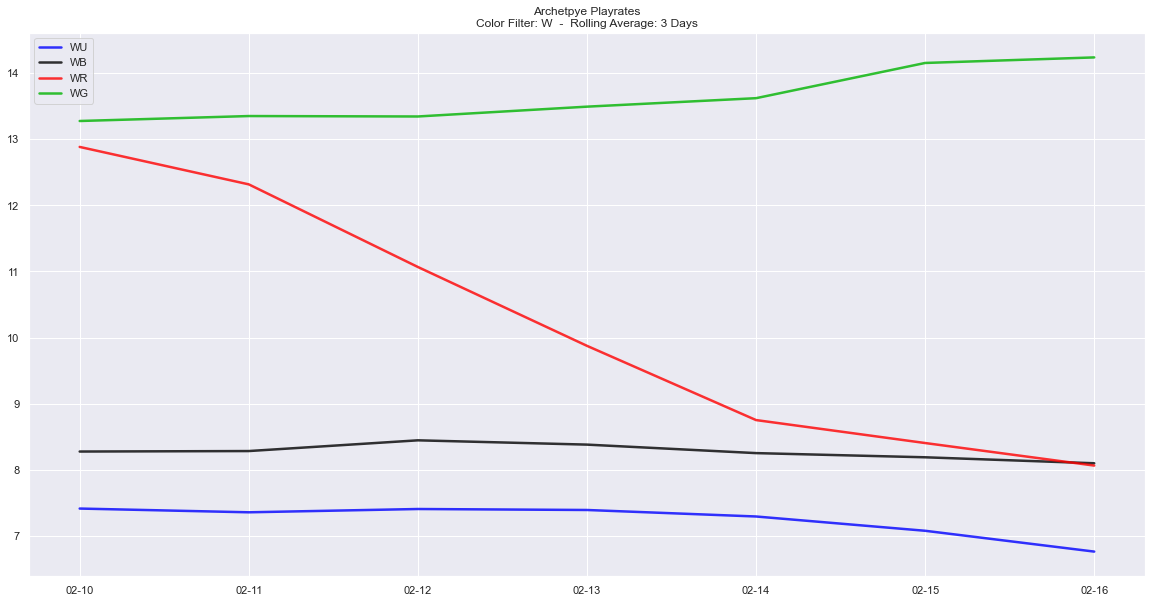

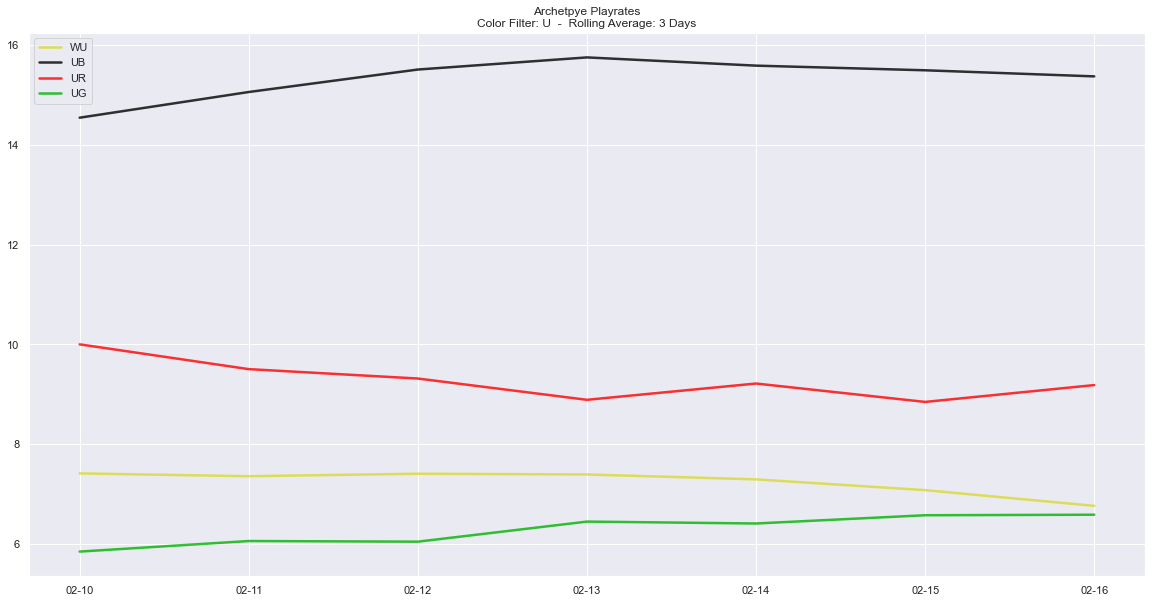

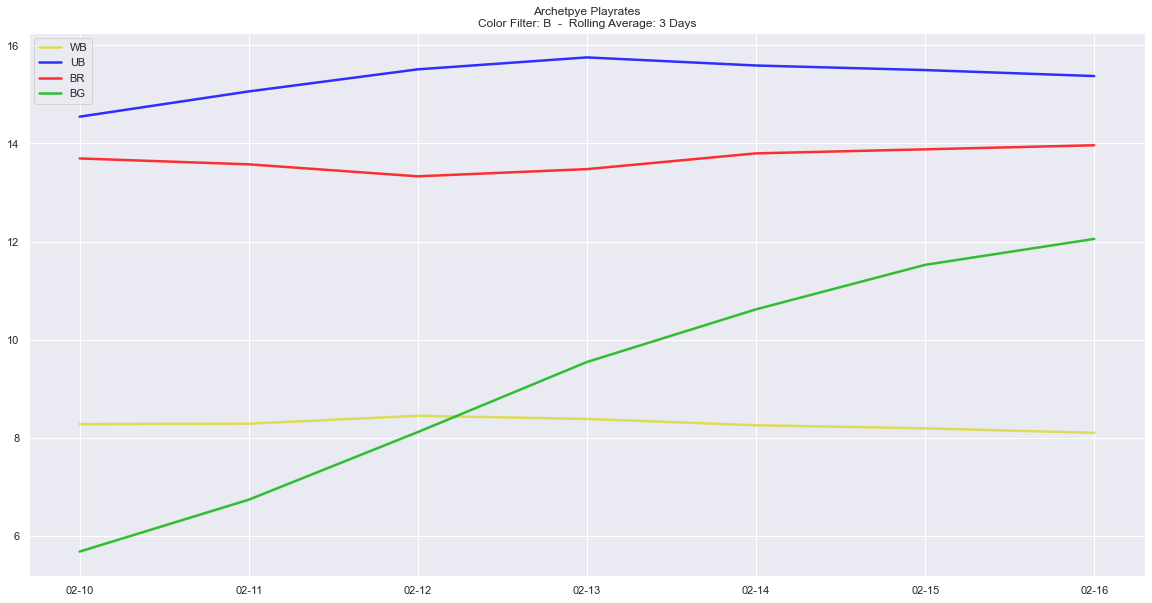

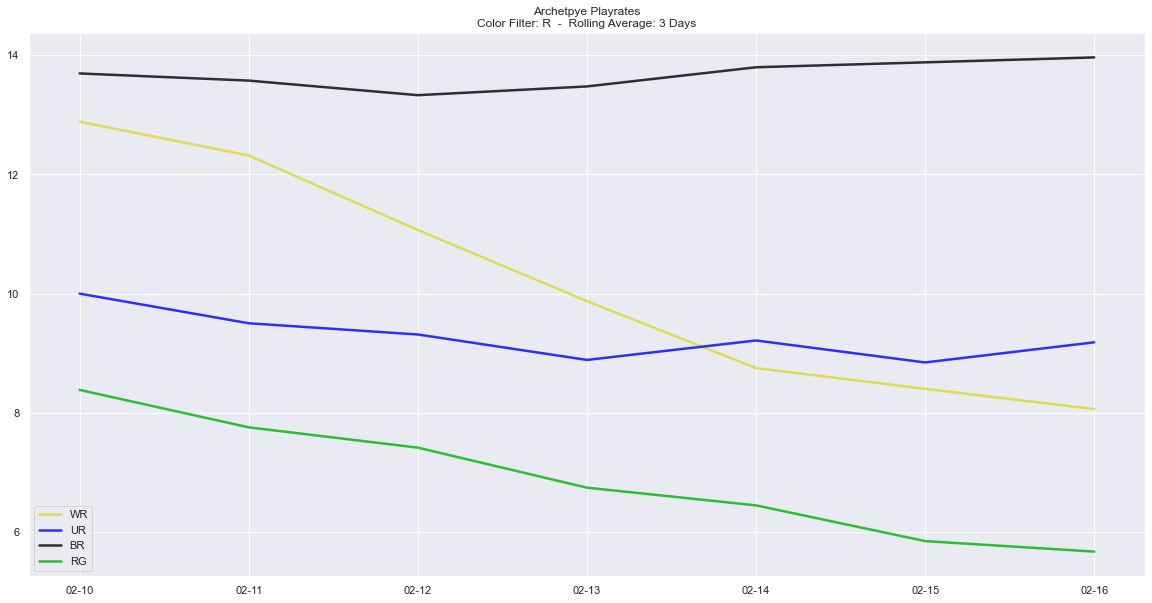

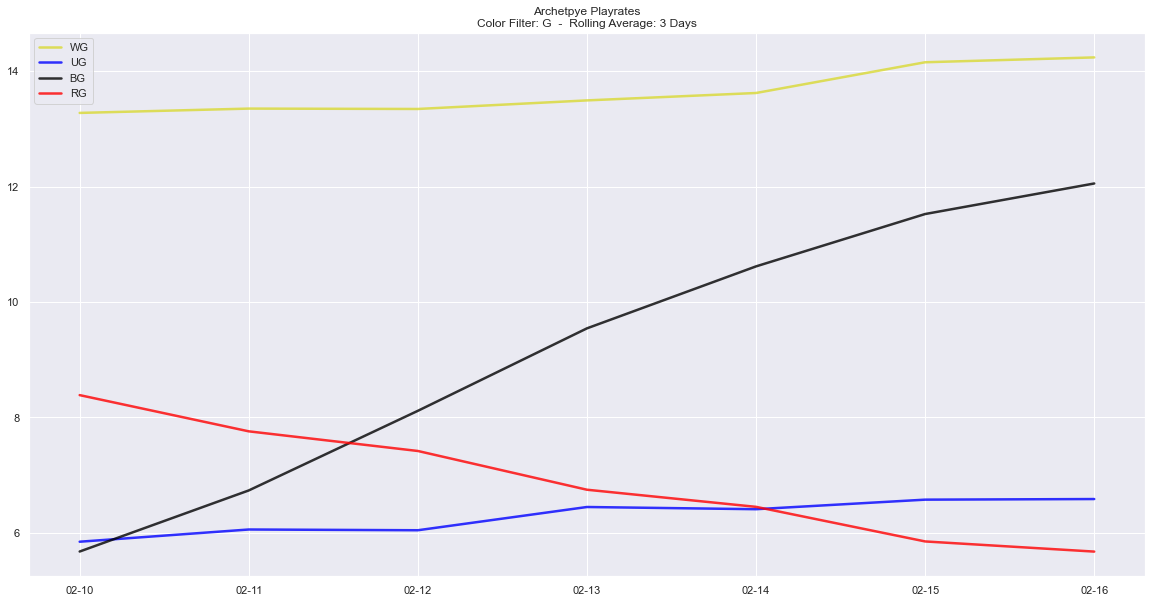

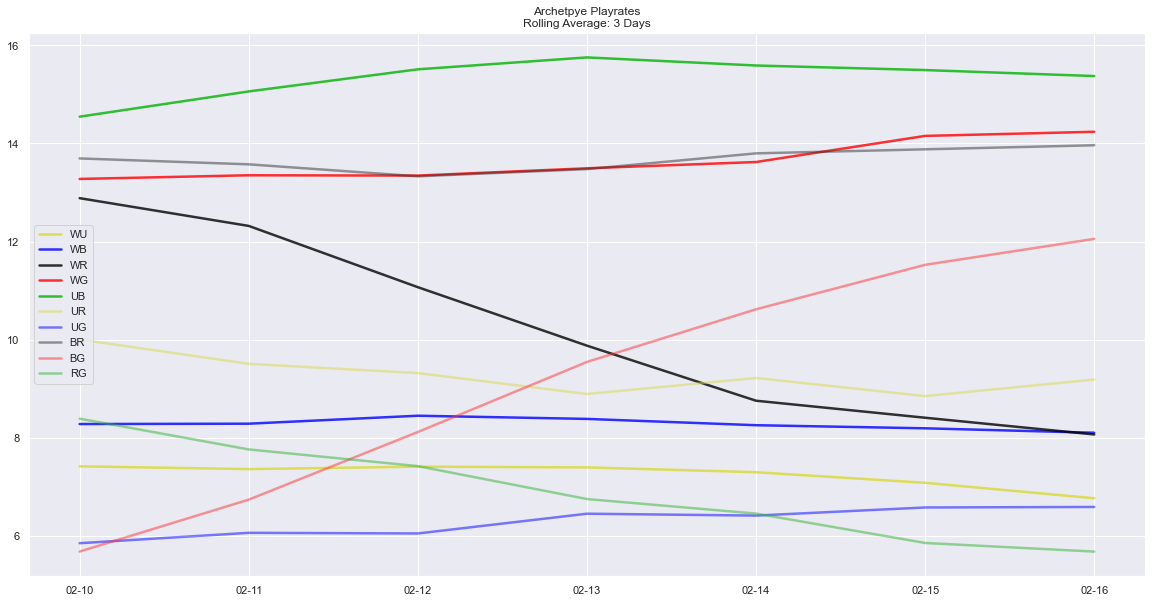

In [20]:
plot_archetype_playrate_history('W', 3)
plot_archetype_playrate_history('U', 3)
plot_archetype_playrate_history('B', 3)
plot_archetype_playrate_history('R', 3)
plot_archetype_playrate_history('G', 3)
plot_archetype_playrate_history('', 3)

## Old Tests

In [ ]:
card_array = {col: manager.card_frame(name='Eiganjo Exemplar', colors=col)[['GIH WR', 'ALSA', '# GP', 'IWD']] for col in color_pairs}
for key in card_array:
    array = card_array[key]
    new_idxs = [tup[0][5:] for tup in array.index]
    array.index = new_idxs
card_array

In [ ]:
#frame = pd.concat(card_array)
frame = card_array['']
frame.plot(subplots=True, layout=(2,2), figsize=(8,8))

In [ ]:
manager.card_frame(name='Virus Beetle', colors='')

In [ ]:
manager.card_frame(name='Leech Gauntlet', colors='')

In [ ]:
day_frame = manager.archetype_frame(date='2022-02-14')
win_rate_frame = win_rate_frame[win_rate_frame['Splash'] == False]
day_frame['Games'].sum()
day_frame

In [ ]:
pd.options.display.float_format = None

In [ ]:
frame = today[2][''].copy()
avg_wr = today[0].loc['All Decks']['Win %']
wu_avg_wr = today[1][today[1]['Colors'] == 'WU'][today[1]['Splash'] == False].iloc[0]['Win %']
#frame['Δ WR'] = None
frame = frame.drop(['# Seen', '# Picked', '# OH', '# GD', '# GIH', '# GND'], axis=1)
frame['(x-μ) GP WR'] = frame['GP WR'] - avg_wr
frame['(x-μ) GIH WR'] = frame['GIH WR'] - avg_wr

frame.sort_values(by=['(x-μ) GP WR'])
frame[frame['(x-μ) GP WR'] < frame['(x-μ) GIH WR']].sort_values(by=['(x-μ) GIH WR'])
frame['Spikiness'] =  frame['GIH WR'] - frame['GP WR']
frame

# Data Graphing and Display

## Card Pick Order Stats

In [ ]:
graph_pick_stats('Voldaren Epicure', 1)

In [ ]:
graph_pick_stats('Imperial Oath', 1)

In [ ]:
graph_pick_stats('Behold the Unspeakable', 3)

In [ ]:
to_graph = ['Imperial Oath', 'Behold the Unspeakable', 'Virus Beetle', 'Network Disruptor']
for card in to_graph:
    graph_pick_stats(card, 1)

## Archetype Winrate History

In [ ]:
get_archtype_winrates_frame('GB', 1)

In [ ]:
get_archtype_winrates_frame('RW', 3)

In [ ]:
plot_archetype_winrate_history('W', 3)
plot_archetype_winrate_history('U', 3)
plot_archetype_winrate_history('B', 3)
plot_archetype_winrate_history('R', 3)
plot_archetype_winrate_history('G', 3)
plot_archetype_winrate_history('', 3)

## Card Pick Order Changes

In [ ]:
diff = compare_card_evaluations('2022-02-10', '2022-02-15')
commons = diff[diff['Rarity'] == 'C']
uncommons = diff[diff['Rarity'] == 'U']

In [ ]:
SRT_TRG = 'Δ ATA'
commons.sort_values(SRT_TRG, ascending=False).head(20)

In [ ]:
commons.sort_values(SRT_TRG, ascending=True).head(20)

In [ ]:
uncommons.sort_values(SRT_TRG, ascending=False).head(10)

In [ ]:
uncommons.sort_values(SRT_TRG, ascending=True).head(10)